# GPT Model

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # <vocabulary> size by BPE tokenizer
    "context_length": 1024, # max number of tokens per sentence
    "emb_dim": 768, # each token will be embedded to this size
    "n_heads": 12, # number of heads in multi-head attention
    "n_layers": 12, # number of transformers blocks
    "drop_rate": 0.1, # dropout rate
    "qkv_bias": False # Query-Key-Value bias in Linear layers
}

## Placeholder GPT model

In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Remind: nn.Embedding is a map <integer-location>=>vector
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        # list of transformers blocks
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        # in_idx: (batch,seq_len); each is list of indices of each word in <vocab>
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx) # (batch,seq_len,embed_dim)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    # normalized_shape == embedding dim
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1))) # 4 indices in <vocab>
batch.append(torch.tensor(tokenizer.encode(txt2))) # 4 indices in <vocab>
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch) # (batch,seq_len,vocab_size)=(2,4,50257)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## Normalizing activations with layer normalization

In [5]:
# Toy example
torch.manual_seed(123)
batch_example = torch.randn(2,5) # (2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example) # (2,6)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [6]:
mean = out.mean(dim=-1, keepdim=True) # (2,1)
var = out.var(dim=-1, keepdim=True) # (2,1)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [7]:
out_norm = (out-mean)/torch.sqrt(var) # (2,6)
mean = out_norm.mean(dim=-1, keepdim=True) # (2,1)
var = out_norm.var(dim=-1, keepdim=True) # (2,1)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Var:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Var:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
# easier to read
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        # optional trainable params
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # (batch,1)
        # biased variance: divided by 1/(n-1)
        # unbiased variance: divided by 1/n
        var = x.var(dim=-1, keepdim=True, unbiased=False) # (batch,1)
        norm_x = (x-mean) / torch.sqrt(var+self.eps) # (batch,emb_dim)
        return self.scale * norm_x + self.shift # (batch,emb_dim)
        

In [12]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example) # (batch,5)
mean = out_ln.mean(dim=-1, keepdim=True) # (batch,)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True) # (batch,)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## GeLU activation function

In [13]:
class GeLU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5*x*(1+torch.tanh( torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3)) ))

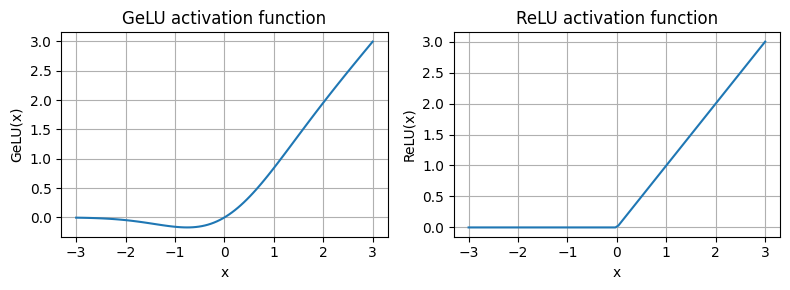

In [15]:
# plot GeLu and ReLU
import matplotlib.pyplot as plt 
gelu, relu = GeLU(), nn.ReLU()

x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y,label) in enumerate(zip([y_gelu, y_relu], ["GeLU", "ReLU"]), 1):
    plt.subplot(1,2,i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GeLU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)
    

In [20]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,GPT_CONFIG_124M["emb_dim"]) #  (batch,num_tokens,embed_dim)
out = ffn(x) # (batch,num_tokens,embed_dim)
print(out.shape)

torch.Size([2, 3, 768])
